In [1]:
import pandas as pd
import pathlib
import geopandas as gpd
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import seaborn as sbn
import cartopy.crs as ccrs
pd.options.display.max_columns = None
pd.options.display.max_rows = None

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:23: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Load the input data

In [2]:
base_path = pathlib.Path("/Users/fabriziofinozzi/Desktop/OpenEnergyTransition/repo/")
base_network_pypsa_earth = pypsa.Network(pathlib.Path(base_path, "geothermal-modelling/workflow/pypsa-earth/networks/US_2021/base.nc"))
base_network_pypsa_usa = pypsa.Network(pathlib.Path(base_path, "pypsa-usa/workflow/resources/Default/usa/elec_base_network.nc"))
eia_base_network = gpd.read_file(pathlib.Path(base_path, "US_Electric_Power_Transmission_Lines_5037807202786552385.geojson"))

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/components.py:318: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/com

The total number of lines in the EIA dataset is

In [3]:
eia_base_network.shape[0]

94216

At first glance, it is possible to see that some transmission lines correspond to a voltage of -999999.0 kV. In particular the number of lines corresponding to -999999.0 is

In [4]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]

14062

which acoounts for almost 15 % of the lines in the EIA dataset

In [5]:
eia_base_network.loc[eia_base_network["VOLTAGE"]==-999999.0].shape[0]/eia_base_network.shape[0]*100

14.9252780844018

For the moment, such lines are filtered out

In [6]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLTAGE"]!=-999999.0]
eia_base_network.shape[0]

80154

Get the voltage bins from the reference data

In [7]:
eia_voltage_bins_flags = eia_base_network["VOLT_CLASS"].unique().tolist()
eia_voltage_bins_flags

['100-161',
 'Under 100',
 '345',
 '220-287',
 '500',
 '735 And Above',
 'Dc',
 'Not Available']

In [8]:
volt_class_min_values = []
volt_class_max_values = []
for bin_name in eia_voltage_bins_flags:
    volt_class_min_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].min())
    volt_class_max_values.append(eia_base_network.loc[eia_base_network["VOLT_CLASS"]==bin_name]["VOLTAGE"].max())
volt_class_bin_limits = pd.DataFrame(
    {
        "voltage_class": eia_voltage_bins_flags,
        "voltage_class_min": volt_class_min_values,
        "voltage_class_max": volt_class_max_values,
    }
)
volt_class_bin_limits

,voltage_class,voltage_class_min,voltage_class_max
0,100-161,100.0,218.0
1,Under 100,3.0,92.0
2,345,345.0,345.0
3,220-287,220.0,287.0
4,500,500.0,500.0
5,735 And Above,765.0,765.0
6,Dc,200.0,1000.0
7,Not Available,169.0,169.0


The voltage classes in the EIA dataset include also *Dc*. The number of lines corresponding to such voltage class is

In [9]:
eia_base_network.loc[eia_base_network["VOLT_CLASS"]=='Dc'].shape[0]

9

Considering that the PyPSA-Earth base network does not contain any DC line

In [10]:
base_network_pypsa_earth.lines["dc"].unique()

array([False])

the lines corresponding to the *Dc* voltage class are removed from the EIA dataset

In [11]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Dc']
eia_base_network.shape[0]

80145

Furthermore, the lines corresponding to the voltage class *Not Available* are removed as well

In [12]:
eia_base_network = eia_base_network.loc[eia_base_network["VOLT_CLASS"]!='Not Available']
eia_base_network.shape[0]

80144

In [13]:
eia_base_network["STATUS"].unique()

array(['In Service', 'Not Available', 'Under Construction', 'Inactive',
       'Proposed'], dtype=object)

In [14]:
base_network_pypsa_earth.lines.shape[0]

24028

# PyPSA-Earth - EIA comparison

Add the voltage class to the PyPSA-Earth base network

In [15]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom"]
base_network_pypsa_earth.lines.head(2)

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,carrier,type,s_max_pu,s_nom,underwater_fraction,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,US,"LINESTRING (-98.2396 26.2599, -98.40958 26.160...","MULTIPOINT ((-98.2396 26.2599), (-98.1734 26.1...",POINT (-98.2396 26.2599),POINT (-98.1734 26.1203),-98.2396,26.2599,-98.1734,26.1203,AC,243-AL1/39-ST1A 20.0,0.7,308.339685,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,138.0
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,US,"LINESTRING (-106.4285 31.7916, -106.3723559999...","MULTIPOINT ((-106.4285 31.7916), (-106.2873 31...",POINT (-106.4285 31.7916),POINT (-106.2873 31.7802),-106.4285,31.7916,-106.2873,31.7802,AC,243-AL1/39-ST1A 20.0,0.7,128.474869,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,115.0


In [16]:
v_nom_class_dict_pypsa_earth = {
    55.: 'Under 100',
    57.1: 'Under 100', 
    60.: 'Under 100',
    66.: 'Under 100',  
    69.: 'Under 100',  
    70.: 'Under 100',  
    88.: 'Under 100', 
    92.: 'Under 100', 
    100.: "100-161",
    115.: "100-161", 
    120.: "100-161",  
    125.: "100-161",  
    138.: "100-161",  
    160.: "100-161",  
    161.: "100-161",
    220.: "220-287",
    230.: "220-287",
    287.: "220-287",
    345.: "345",
    500.: "500",
    765.: "735 And Above"
}

In [17]:
base_network_pypsa_earth.lines["v_nom_class"] = base_network_pypsa_earth.lines["v_nom_class"].replace(v_nom_class_dict_pypsa_earth)
base_network_pypsa_earth.lines.head(2)

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,country,geometry,bounds,bus_0_coors,bus_1_coors,bus0_lon,bus0_lat,bus1_lon,bus1_lat,carrier,type,s_max_pu,s_nom,underwater_fraction,x,r,g,b,s_nom_extendable,s_nom_min,s_nom_max,capital_cost,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt,v_nom_class
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,line,138.0,2.0,60.0,3501,5496,NaN,False,False,False,US,"LINESTRING (-98.2396 26.2599, -98.40958 26.160...","MULTIPOINT ((-98.2396 26.2599), (-98.1734 26.1...",POINT (-98.2396 26.2599),POINT (-98.1734 26.1203),-98.2396,26.2599,-98.1734,26.1203,AC,243-AL1/39-ST1A 20.0,0.7,308.339685,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161
1,line,115.0,1.0,60.0,714,10809,NaN,False,False,False,US,"LINESTRING (-106.4285 31.7916, -106.3723559999...","MULTIPOINT ((-106.4285 31.7916), (-106.2873 31...",POINT (-106.4285 31.7916),POINT (-106.2873 31.7802),-106.4285,31.7916,-106.2873,31.7802,AC,243-AL1/39-ST1A 20.0,0.7,128.474869,0.0,0.0,0.0,0.0,0.0,False,0.0,inf,0.0,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100-161


### Count plot

[Text(0.5, 1.0, 'PyPSA-Earth base network')]

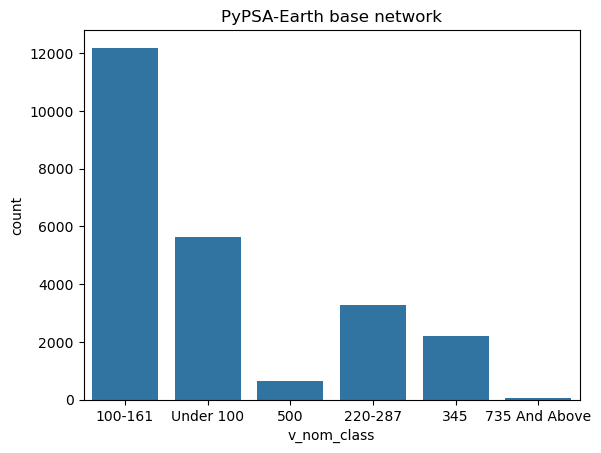

In [18]:
sbn.countplot(data=base_network_pypsa_earth.lines, x=base_network_pypsa_earth.lines["v_nom_class"]).set(title='PyPSA-Earth base network')

[Text(0.5, 1.0, 'EIA network topology')]

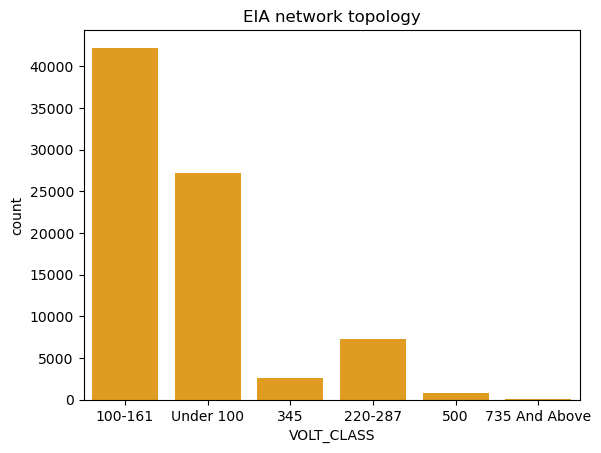

In [19]:
sbn.countplot(data=eia_base_network, x=eia_base_network["VOLT_CLASS"], color="orange").set(title='EIA network topology')

### Maps

In [20]:
# Available voltage classes are:
# Under 100
# 100-161
# 220-287
# 345
# 500
# 735 And Above

selected_voltage_class_earth = "735 And Above"

In [21]:
base_network_pe_volt_class = base_network_pypsa_earth.lines.loc[base_network_pypsa_earth.lines["v_nom_class"] == selected_voltage_class_earth]
base_network_pe_volt_class = gpd.GeoDataFrame(base_network_pe_volt_class, geometry=gpd.GeoSeries.from_wkt(base_network_pe_volt_class.geometry), crs="EPSG:4326")
base_network_pe_volt_class["union_geo"] = 0
base_network_pe_volt_class = base_network_pe_volt_class.dissolve(by="union_geo")
base_network_pe_volt_class = base_network_pe_volt_class.to_crs(3857)

eia_base_network_volt_class = eia_base_network.loc[eia_base_network["VOLT_CLASS"]==selected_voltage_class_earth]
eia_base_network_volt_class["union_geo"] = 0
eia_base_network_volt_class = eia_base_network_volt_class.dissolve(by="union_geo")
eia_base_network_volt_class = eia_base_network_volt_class.to_crs(3857)

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [28]:
base_network_pe_volt_class.geometry

union_geo
0    MULTILINESTRING ((-9095537.106 4426708.585, -9...
Name: geometry, dtype: geometry

/opt/anaconda3/envs/pypsa-earth/lib/python3.10/site-packages/shapely/set_operations.py:131: RuntimeWarning:

invalid value encountered in intersection



<AxesSubplot:>

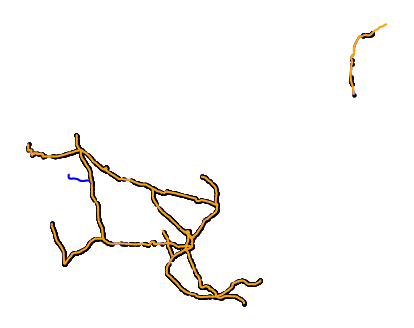

In [58]:
intersection_geometries = base_network_pe_volt_class.intersection(eia_base_network_volt_class)
fig, ax = plt.subplots(figsize=(20, 4))
ax.set_axis_off()

intersection_geometries.plot(ax=ax, color="black", markersize=5)
base_network_pe_volt_class.plot(ax=ax, color="blue", kind="geo")
eia_base_network_volt_class.plot(ax=ax, color="orange", kind="geo")

In [23]:
!pip install -U kaleido

In [36]:
import plotly.express as px
import shapely
import kaleido

lats = []
lons = []

for feature in zip(base_network_pe_volt_class.geometry):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)

fig = px.line_map(lat=lats, lon=lons)
fig.write_image("plotly_test.png")

In [25]:
fig.savefig("network_comparison_for_voltage_class_{}.png".format(str(selected_voltage_class_earth)))

AttributeError: 'Figure' object has no attribute 'savefig'

In [ ]:
eia_base_network_765["union_geo"] = 0
eia_base_network_new = eia_base_network_765.dissolve(by="union_geo")
eia_base_network_new

In [ ]:
base_network_pypsa_earth.lines["line_width"] = 0.0
base_network_pypsa_earth.lines.loc[base_network_pypsa_earth.lines["v_nom_class"] == selected_voltage_class_earth, "line_width"] = 1.0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, subplot_kw={"projection":ccrs.PlateCarree(), "projection":ccrs.PlateCarree()}, figsize=(20, 4))
base_network_pypsa_earth.plot(line_widths = base_network_pypsa_earth.lines["line_width"], bus_sizes = 0, line_colors = "blue", ax=ax1)
base_network_pypsa_earth.plot(line_widths = base_network_pypsa_earth.lines["line_width"], bus_sizes = 0, line_colors = "white", ax=ax2)
eia_base_network.loc[eia_base_network["VOLT_CLASS"]==selected_voltage_class_earth].plot(ax=ax2, color="orange")
fig.suptitle("Comparison for voltage class: {}".format(selected_voltage_class_earth))
ax1.set_aspect('equal')
ax1.title.set_text("PyPSA-Earth base network")
ax2.set_aspect("equal")
ax2.title.set_text("EIA network")

# PyPSA-USA - EIA comparison

Add the voltage class to the PyPSA-USA base network

In [ ]:
base_network_pypsa_usa.lines["v_nom_class"] = base_network_pypsa_usa.lines["v_nom"]
base_network_pypsa_usa.lines.head(2)

In [ ]:
base_network_pypsa_usa.lines.v_nom.unique()

In [ ]:
v_nom_class_dict_pypsa_usa = {
    69.: 'Under 100',
    100.: "100-161",
    138.: "100-161", 
    115.: "100-161", 
    161.: "100-161",
    230.: "220-287",
    345.: "345",
    500.: "500",
    765.: "735 And Above"
}

In [ ]:
base_network_pypsa_usa.lines["v_nom_class"] = base_network_pypsa_usa.lines["v_nom_class"].replace(v_nom_class_dict_pypsa_usa)

### Maps

In [ ]:
# Available voltage classes are:
# Under 100
# 100-161
# 220-287
# 345
# 500
# 735 And Above

selected_voltage_class_usa = "735 And Above"

In [ ]:
base_network_pypsa_usa.lines["line_width"] = 0.0
base_network_pypsa_usa.lines.loc[base_network_pypsa_usa.lines["v_nom_class"] == selected_voltage_class_usa, "line_width"] = 1.0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, subplot_kw={"projection":ccrs.PlateCarree(), "projection":ccrs.PlateCarree()}, figsize=(20, 4))
base_network_pypsa_usa.plot(line_widths = base_network_pypsa_usa.lines["line_width"], bus_sizes = 0, line_colors = "blue", ax=ax1)
base_network_pypsa_usa.plot(line_widths = base_network_pypsa_usa.lines["line_width"], bus_sizes = 0, line_colors = "white", ax=ax2)
eia_base_network.loc[eia_base_network["VOLT_CLASS"]==selected_voltage_class_usa].plot(ax=ax2, color="orange")
fig.suptitle("Comparison for voltage class: {}".format(selected_voltage_class_usa))
ax1.set_aspect('equal')
ax1.title.set_text("PyPSA-USA base network")
ax2.set_aspect("equal")
ax2.title.set_text("EIA network")

In [ ]:
fig.savefig("network_comparison_pusa_for_voltage_class_{}.png".format(str(selected_voltage_class_usa)))

## Compare crossings

In [ ]:
gadm_usa_json_path_level_1 = "/Users/fabriziofinozzi/Desktop/OpenEnergyTransition/repo/geothermal-modelling/analysis/data/gadm41_USA_1.json"
gadm_gdp_usa_level_1 = gpd.read_file(gadm_usa_json_path_level_1)

In [ ]:
gadm_gdp_usa_level_1.head(2)

Apply a spatial join between the reference transmission lines topology from EIA and the GADM shapes (level 1)

In [ ]:
spatial_join_gadm_eia = eia_base_network.sjoin(gadm_gdp_usa_level_1, how="inner")
spatial_join_gadm_eia.head(2)

In [ ]:
spatial_join_gadm_eia[["ID", "GID_1", "VOLTAGE", "VOLT_CLASS", "ISO_1", "NAME_1"]].head(2)

Apply a spatial join between the transmission lines topology from the PyPSA-Earth base network and the GADM shapes (level 1)

In [ ]:
base_network_pypsa_earth_geopandas = gpd.GeoDataFrame(base_network_pypsa_earth.lines, geometry=gpd.GeoSeries.from_wkt(base_network_pypsa_earth.lines.geometry), crs="EPSG:4326")

In [ ]:
spatial_join_gadm_pypsa_earth = base_network_pypsa_earth_geopandas.sjoin(gadm_gdp_usa_level_1, how="inner")
spatial_join_gadm_pypsa_earth.head(5)

In [ ]:
spatial_join_gadm_pypsa_earth[["GID_1", "v_nom", "v_nom_class", "type", "num_parallel", "ISO_1", "NAME_1"]].head(2)